In [1]:
%%capture
import numpy as np               # computation
import pandas as pd              # Reading data csv
import matplotlib.pyplot as plt  # Plotting graph
import seaborn as sb
from sklearn.model_selection import train_test_split

# Text Pre-processing libraries
import nltk
import string
import warnings
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

# Tensorflow imports to build the model.
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import onnx
import pickle

nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
warnings.filterwarnings('ignore')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   24783 non-null  int64 
 1   tweet   24783 non-null  object
dtypes: int64(1), object(1)
memory usage: 387.4+ KB


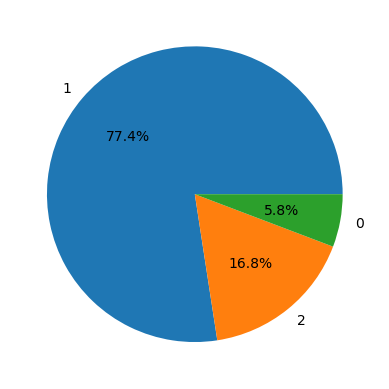

In [2]:

# Load dataset
df = pd.read_csv('Dataset.csv')
df.head()
df.shape
df.info()

# Visualizing class distribution
plt.pie(df['class'].value_counts().values,
        labels = df['class'].value_counts().index,
        autopct='%1.1f%%')
plt.show()



In [3]:
# Lowercase the text and remove punctuations
df['tweet'] = df['tweet'].str.lower()

punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)

df['tweet'] = df['tweet'].apply(lambda x: remove_punctuations(x))

# Remove stopwords (the, and, a) and lemmatize words (convert to root word, running -> run)
# Store important words
def remove_stopwords(text):
    stop_words = stopwords.words('english')
    imp_words = []
    lemmatizer = WordNetLemmatizer()
    for word in str(text).split():
        if word not in stop_words:
            imp_words.append(lemmatizer.lemmatize(word))
    return " ".join(imp_words)

df['tweet'] = df['tweet'].apply(lambda text: remove_stopwords(text))


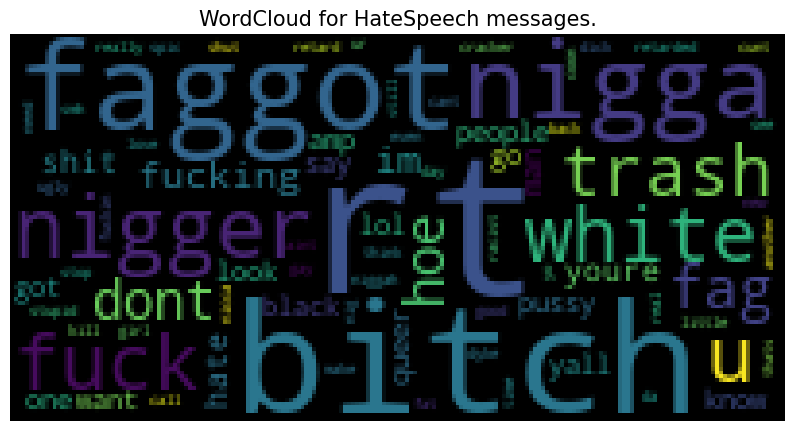

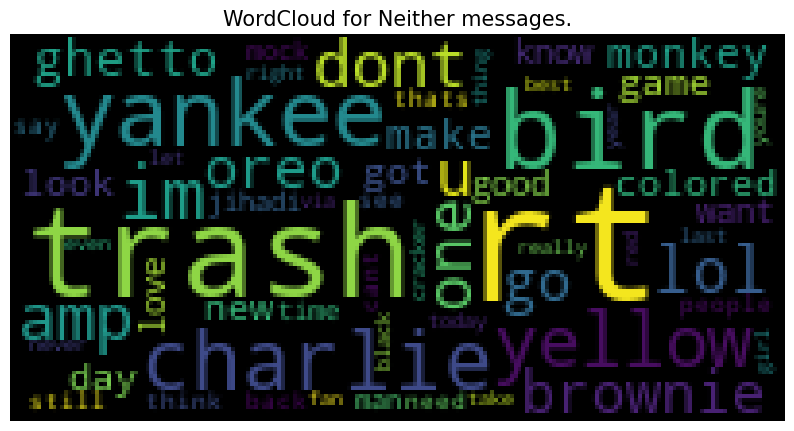

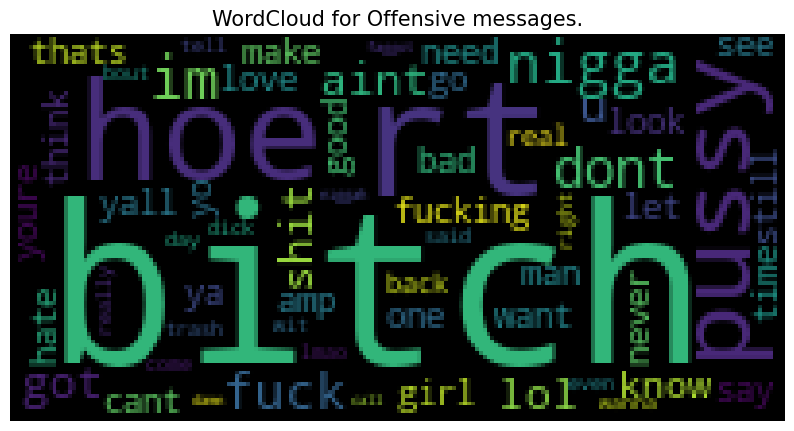

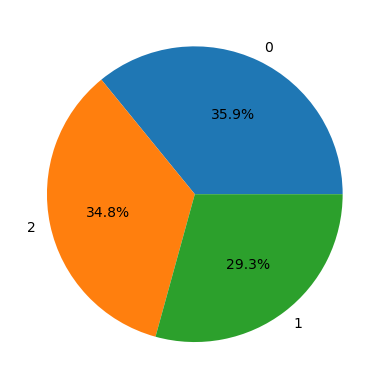

In [4]:

# Plot word cloud for 'Neither' class
def plot_word_cloud(data, typ):
    email_corpus = " ".join(data['tweet'])
    plt.figure(figsize = (10,10))
    wc = WordCloud(max_words = 100, width = 200, height = 100, collocations = False).generate(email_corpus)
    plt.title(f'WordCloud for {typ} messages.', fontsize = 15)
    plt.axis('off')
    plt.imshow(wc)
    plt.show()
    
plot_word_cloud(df[df['class'] == 0], typ='HateSpeech')
plot_word_cloud(df[df['class'] == 2], typ='Neither')
plot_word_cloud(df[df['class'] == 1], typ='Offensive')

# Balancing classes
class_2 = df[df['class'] == 2]
class_1 = df[df['class'] == 1].sample(n=3500)
class_0 = df[df['class'] == 0]

balanced_df = pd.concat([class_0, class_0, class_0, class_1, class_2], axis=0)

# Visualizing the balanced dataset
plt.pie(balanced_df['class'].value_counts().values,
        labels=balanced_df['class'].value_counts().index,
        autopct='%1.1f%%')
plt.show()


In [5]:

# Features and Target
features = balanced_df['tweet']
target = balanced_df['class']

X_train, X_val, Y_train, Y_val = train_test_split(features, target, test_size=0.2, random_state=22)

# One-hot encoding target labels
Y_train = pd.get_dummies(Y_train)
Y_val = pd.get_dummies(Y_val)

# Tokenization
max_words = 5000
max_len = 100

token = Tokenizer(num_words=max_words, lower=True, split=' ')
token.fit_on_texts(X_train)
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(token, f)
# Converting texts to sequences and padding them
X_train_seq = token.texts_to_sequences(X_train)
X_val_seq = token.texts_to_sequences(X_val)

X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=max_len, padding='post', truncating='post')


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.6591 - loss: 3.7800 - val_accuracy: 0.4571 - val_loss: 1.0001 - learning_rate: 0.0010
Epoch 2/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8977 - loss: 0.3961 - val_accuracy: 0.7834 - val_loss: 0.6246 - learning_rate: 0.0010
Epoch 3/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9421 - loss: 0.2569 - val_accuracy: 0.8854 - val_loss: 0.4110 - learning_rate: 0.0010
Epoch 4/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.9494 - loss: 0.2165 - val_accuracy: 0.8749 - val_loss: 0.4902 - learning_rate: 0.0010
Epoch 5/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.9626 - loss: 0.1805 - val_accuracy: 0.8595 - val_loss: 0.5579 - learning_rate: 0.0010
Epoch 6/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.9761 - loss: 0.1408 - val_accuracy: 0.8461 - val_loss: 0.5532 - learning_rate: 0.0010
Epoch 7/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.9760 - loss: 0.

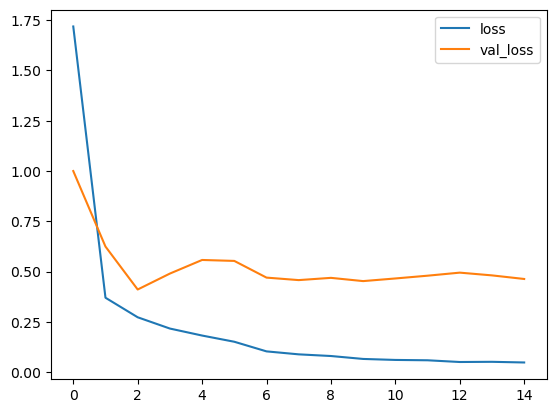

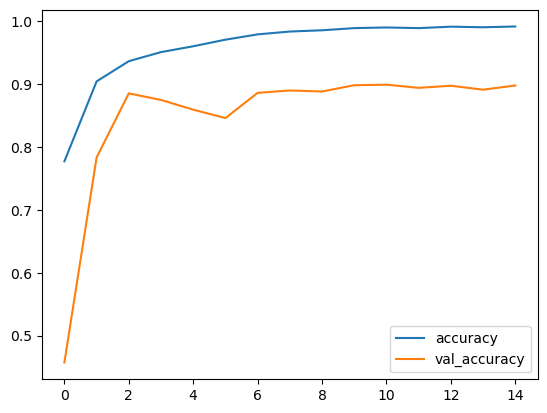

In [6]:

# Model building
model = keras.models.Sequential([
    layers.Embedding(input_dim=max_words, output_dim=32, input_length=max_len),  # Specify input_length
    layers.Bidirectional(layers.LSTM(16)),
    layers.Dense(512, activation='relu', kernel_regularizer='l1'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Model summary
model.summary()

# Callbacks
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

es = EarlyStopping(patience=4,
                   monitor='val_accuracy',
                   restore_best_weights=True)

lr = ReduceLROnPlateau(patience=3,
                       monitor='val_loss',
                       factor=0.5,
                       verbose=0)

# Model fitting
history = model.fit(X_train_padded, Y_train,
                    validation_data=(X_val_padded, Y_val),
                    epochs=50,
                    batch_size=32,
                    callbacks=[lr, es])

# Plotting history
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
plt.show()


In [7]:
# Sample sentence for testing
test_sentence = "Today is a great day"

# Step 1: Preprocess the sentence
test_sentence = test_sentence.lower()  # Convert to lowercase
test_sentence = remove_punctuations(test_sentence)  # Remove punctuation
test_sentence = remove_stopwords(test_sentence)  # Remove stopwords

# Step 2: Tokenize the sentence
test_seq = token.texts_to_sequences([test_sentence])

# Step 3: Pad the sequence
test_padded = pad_sequences(test_seq, maxlen=max_len, padding='post', truncating='post')

# Step 4: Predict the class
prediction = model.predict(test_padded)

# Output the predicted class
predicted_class = np.argmax(prediction, axis=1)

# Map the prediction to the corresponding label
class_labels = ['Hate Speech', 'Offensive', 'Neither']  # Adjust this if your labels are different
print("Test Sentence: Today is a good day")
print(f"Predicted class: {class_labels[predicted_class[0]]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
Test Sentence: Today is a good day
Predicted class: Neither


In [8]:
# Sample sentence for testing
test_sentence = "I hate you bitch"
print("Test sentence :", test_sentence)
# Step 1: Preprocess the sentence
test_sentence = test_sentence.lower()  # Convert to lowercase
test_sentence = remove_punctuations(test_sentence)  # Remove punctuation
test_sentence = remove_stopwords(test_sentence)  # Remove stopwords

# Step 2: Tokenize the sentence
test_seq = token.texts_to_sequences([test_sentence])

# Step 3: Pad the sequence
test_padded = pad_sequences(test_seq, maxlen=max_len, padding='post', truncating='post')

# Step 4: Predict the class
prediction = model.predict(test_padded)

# Output the predicted class
predicted_class = np.argmax(prediction, axis=1)

# Map the prediction to the corresponding label
class_labels = ['Hate Speech', 'Offensive', 'Neither']  # Adjust this if your labels are different
print(f"Predicted class: {class_labels[predicted_class[0]]}")


Test sentence : I hate you bitch
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted class: Offensive


In [9]:
model.save("hate_speech_model.keras")

In [10]:
import tensorflow as tf
import tf2onnx

# Load the Keras model
model = tf.keras.models.load_model("hate_speech_model.keras")
model.output_names = ['output']

# Define input signature explicitly (batch size=None for dynamic batching)
spec = (tf.TensorSpec(shape=[None, max_len], dtype=tf.float32),)  # Ensure max_len is defined

# Convert the model to ONNX format
onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature=spec)

# Save the ONNX model
with open("hate_speech_model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

print("Model successfully converted to ONNX format!")


Model successfully converted to ONNX format!


In [11]:
import onnxruntime as ort
import numpy as np

# Sample sentence
test_sentence = "I hate you bitch "
print(f"Test Sentence: {test_sentence}")

# Preprocess the sentence
test_sentence = test_sentence.lower()  # Convert to lowercase
test_sentence = remove_punctuations(test_sentence)  # Remove punctuation
test_sentence = remove_stopwords(test_sentence)  # Remove stopwords

# Tokenize the sentence
test_seq = token.texts_to_sequences([test_sentence])

# Pad the sequence
test_padded = pad_sequences(test_seq, maxlen=max_len, padding='post', truncating='post')

# Convert to float32 (required for ONNX)
test_padded = test_padded.astype(np.float32)

# Load ONNX model
session = ort.InferenceSession("hate_speech_model.onnx")

# Get input and output names
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

# Run inference
outputs = session.run([output_name], {input_name: test_padded})

# Get the predicted class
predicted_class = np.argmax(outputs[0], axis=1)

# Map the prediction to class labels
class_labels = ['Hate Speech', 'Offensive', 'Neither']  # Adjust if your labels are different
print(f"Predicted class: {class_labels[predicted_class[0]]}")


Test Sentence: I hate you bitch 
Predicted class: Offensive
